In [1]:
#################
#### IMPORTS ####
#################

# Arrays
import numpy as np
import cytoolz

# Deep Learning stuff
import torch
import torchvision
import torchvision.transforms as transforms

# Images display and plots
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl

# Fancy progress bars
import tqdm.notebook as tq

# Tensor Network Stuff
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn # Tensor Network library
import quimb

import collections
import opt_einsum as oe
import itertools
import copy


In [2]:
import sys, os
sys.path.insert(0, '../')
# My functions
from TNutils import *


In [3]:
np.exp(-0.02*np.arange(10)  )

array([1.        , 0.98019867, 0.96078944, 0.94176453, 0.92311635,
       0.90483742, 0.88692044, 0.86935824, 0.85214379, 0.83527021])

In [4]:
class mps_lr:
    def __init__(self, mps, lr0, momentum, s_factor):
        self.sites = len(mps.tensors)
        self.lr0 = lr0
        self.curr_lr = self.lr0
        self.momentum = momentum
        self.t = 0
        self.s_factor = s_factor
        self.past_grad = (self.sites-1)*[0]
        
    
    def clear(self):
        self.t = 0
    
    def compute_lr(self, t):
        '''
        Lr will be annealed each epoch through an exponential function that
        takes into account the baseline value
        '''
        return ((self.lr0)*np.exp(-self.s_factor*self.t  ) )
    
    def new_epoch(self):
        '''
        Update curr lr to the next timestep
        '''
        self.t = self.t + 1
        self.curr_lr = self.compute_lr(self.t)
    
    def J(self, left_index, dNLL):
        '''
        J^{k+1} = \beta J^{k} + dNLL^{k}
        A^{k+1} = A^{k} - lr* J^{k+1}
        '''
        if self.t > 0:
            J = self.momentum * self.past_grad[left_index] + dNLL
        else:
            J = dNLL
        
        self.past_grad[left_index] = np.mean(dNLL.data)/dNLL.data.max()
        
        return J
            

In [5]:
train_set, test_set = get_data()


In [6]:
train_set = meanpool2d(train_set, (28,28))
test_set = meanpool2d(test_set, (28,28))


In [7]:
print('Shape of the training set: {}'.format(train_set.shape) )
print('Shape of the test set:     {}'.format(test_set.shape) )


Shape of the training set: (1000, 196)
Shape of the test set:     (100, 196)


In [8]:
import time
from matplotlib.ticker import MaxNLocator

def plot_nll(nlls,baseline):
    plt.plot(nlls)
    plt.title('Negative log-likelihood')
    plt.axhline(baseline,color = 'r', linestyle= 'dashed')
    plt.legend(['training set','baseline'])
    plt.xlabel('epochs')
    plt.ylabel(r'$\mathcal{L}$')
    #plt.xaxis.set_major_locator(MaxNLocator(integer=True))


def training_and_probing(
    period_epochs,
    periods,
    mps,
    _imgs,
    img_cache,
    batch_size,
    initial_lr = 0.5, 
    lr_update = lambda x: x,
    val_imgs = None,
    period_samples = 0,
    corrupted_set = None,
    plot = False,
    **kwargs):
    # Initialize the training costs
    train_costs = [computeNLL_cached(mps, _imgs, img_cache,0)]

    # TODO: adapt computeNLL to tneinsum3
    if val_imgs:
        # Initialize the validation costs
        val_costs = [computeNLL(mps, val_imgs, 0)]


    samples = []
    lr = initial_lr

    # begin the iteration
    for period in range(periods):
        costs = learning_epoch_cached(mps,_imgs,period_epochs,lr,img_cache,batch_size = batch_size,**kwargs)
        train_costs.extend(costs)
        if val_imgs:
            val_costs.append(computeNLL(mps, val_imgs, 0))
        lr = lr_update(lr)
        if plot:
            plot_nll(train_costs,np.log(len(_imgs)))
            plt.show()
            time.sleep(2)

        # TODO: friendlier sampling strategy
        for i in range(period_samples):
            samples.append(generate_sample(mps))

    return train_costs, samples
        
        


In [9]:
initial_bdim = 16
train_size = 1000

# Convert accordingly
_imgs = np.array([tens_picture(img) for img in train_set[:train_size]])

# Initialize MPS
mps = initialize_mps(_imgs.shape[1],bdim=initial_bdim)

# Initialize the cache
img_cache = left_right_cache(mps,_imgs[:])

epoch 1/1


  0%|          | 0/390 [00:00<?, ?it/s]

NLL: 49.13123885776671 | Baseline: 6.907755278982137


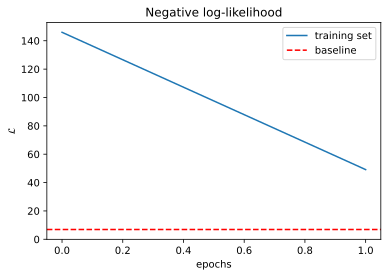

epoch 1/1


  0%|          | 0/390 [00:00<?, ?it/s]

NLL: 36.71908071976362 | Baseline: 6.907755278982137


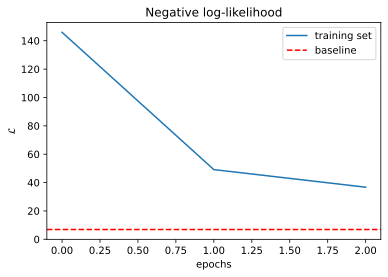

epoch 1/1


  0%|          | 0/390 [00:00<?, ?it/s]

NLL: 30.10016521281117 | Baseline: 6.907755278982137


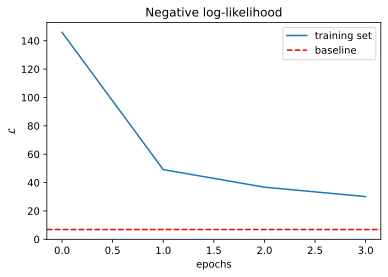

In [10]:
period_epochs = 1
periods = 3
batch_size = 200
max_bond = 300


nlls, samples = training_and_probing(
    period_epochs,
    periods,
    mps,
    _imgs,
    img_cache,
    batch_size,
    initial_lr = 0.08, 
    lr_update = lambda x: x/2,
    val_imgs = None,
    period_samples = 0,
    corrupted_set = None,
    plot = True,
    max_bond = max_bond)


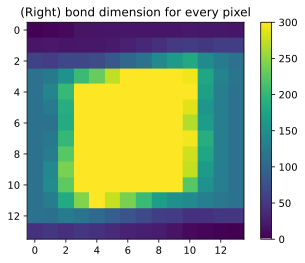

In [11]:
bdims_imshow(mps,(14,14))

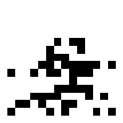

In [12]:
plot_img(generate_sample(mps),(14,14))

In [13]:
def learning_step_cached(mps, index, _imgs, lr, img_cache, going_right = True, **kwargs):
    '''
    Compute the updated merged tensor A_{index,index+1}
    
      UPDATE RULE:  A_{i,i+1} += lr* 2 *( A_{i,i+1}/Z - ( SUM_{i=1}^{m} psi'(v)/psi(v) )/m )
    '''

    # Merge I_k and I_{k+1} in a single rank 4 tensor ('i_{k-1}', 'v_k', 'i_{k+1}', 'v_{k+1}')
    A = qtn.tensor_contract(mps[index],mps[index+1])
    Z = qtn.tensor_contract(A,A)

    # Computing the second term, summation over
    # the data-dependent terms
    psi_primed_arr = arr_psi_primed_cache(_imgs,img_cache,index)

    # Generate magical terms
    psi = tneinsum3(np.array(len(_imgs)*[A]),psi_primed_arr)
    psifrac = sum(psi_primed_arr/into_data(psi))
    psifrac = psifrac/len(_imgs)

    # Derivative of the NLL
    dNLL = (A/Z) - psifrac
    
    A = A - lr.curr_lr*lr.J(index, dNLL) # Update A_{i,i+1}
    A = A/A.data.max()#np.sqrt( tneinsum2(A,A).data )
    # Now the tensor A_{i,i+1} must be split in I_k and I_{k+1}.
    # To preserve canonicalization:
    # > if we are merging sliding towards the RIGHT we need to absorb right
    #                                           S  v  D
    #     ->-->--A_{k,k+1}--<--<-   =>   ->-->-->--x--<--<--<-   =>    >-->-->--o--<--<-
    #      |  |    |   |    |  |          |  |  |   |    |  |          |  |  |  |  |  |
    #
    # > if we are merging sliding toward the LEFT we need to absorb left
    #
    if going_right:
        # FYI: split method does apply SVD by default
        # there are variations of svd that can be inspected
        # for a performance boost
        if index == 0:
            SD = A.split(['v'+str(index)], absorb='right', **kwargs)
        else:
            SD = A.split(['i'+str(index-1),'v'+str(index)], absorb='right',**kwargs)
    else:
        if index == 0:
            SD = A.split(['v'+str(index)], absorb='left', **kwargs)
        else:
            SD = A.split(['i'+str(index-1),'v'+str(index)], absorb='left',**kwargs)

    # SD.tensors[0] -> I_{index}
    # SD.tensors[1] -> I_{index+1}
    return SD

def learning_epoch_cached(mps, _imgs, epochs, lr,img_cache,batch_size = 25,**kwargs):
    '''
    Manages the sliding left and right.
    From tensor 1 (the second), apply learning_step() sliding to the right
    At tensor max-2, apply learning_step() sliding to the left back to tensor 1
    '''
    # We expect, however, that the batch size is smaler than the input set
    batch_size = min(len(_imgs),batch_size)
    guide = np.arange(len(_imgs))
    # Execute the epochs
    cost = []
    for epoch in range(epochs):
        print(f'epoch {epoch+1}/{epochs}')
        # [1,2,...,780,781,780,...,2,1]
        #progress = tq.tqdm([i for i in range(0,len(mps.tensors)-1)] + [i for i in range(len(mps.tensors)-3,0,-1)], leave=True)
        #progress = tq.tqdm([i for i in range(1,len(mps.tensors)-2)] + [i for i in range(len(mps.tensors)-3,0,-1)], leave=True)
        progress = tq.tqdm([i for i in range(0,len(mps.tensors)-1)] + [i for i in range(len(mps.tensors)-2,-1,-1)], leave=True)

        going_right = True
        for index in progress:
            np.random.shuffle(guide)
            mask = guide[:batch_size]
            A = learning_step_cached(mps,index,_imgs[mask],lr,img_cache[mask],going_right,**kwargs)
            if index == 0:
                mps.tensors[index].modify(data=np.transpose(A.tensors[0].data,(1,0)))
                mps.tensors[index+1].modify(data=A.tensors[1].data)
            else:
                mps.tensors[index].modify(data=np.transpose(A.tensors[0].data,(0,2,1)))
                mps.tensors[index+1].modify(data=A.tensors[1].data)

            # Update the cache for all images (for all? really?)
            sequential_update(mps,_imgs,img_cache,index,going_right)
            #p0 = computepsi(mps,imgs[0])**2
            progress.set_description('Left Index: {}'.format(index))

            if index == len(mps.tensors)-2:
                going_right = False
        nll = computeNLL_cached(mps, _imgs, img_cache,0)
        lr.new_epoch()
        print('NLL: {} | Baseline: {}'.format(nll, np.log(len(_imgs)) ) )
        cost.append(nll)
    # cha cha real smooth
    return cost

In [14]:
import time
from matplotlib.ticker import MaxNLocator

def plot_nll(nlls,baseline):
    plt.plot(nlls)
    plt.title('Negative log-likelihood')
    plt.axhline(baseline,color = 'r', linestyle= 'dashed')
    plt.legend(['training set','baseline'])
    plt.xlabel('epochs')
    plt.ylabel(r'$\mathcal{L}$')
    #plt.xaxis.set_major_locator(MaxNLocator(integer=True))


def training_and_probing(
    period_epochs,
    periods,
    mps,
    _imgs,
    img_cache,
    batch_size,
    lr,
    val_imgs = None,
    period_samples = 0,
    corrupted_set = None,
    plot = False,
    **kwargs):
    # Initialize the training costs
    train_costs = [computeNLL_cached(mps, _imgs, img_cache,0)]

    # TODO: adapt computeNLL to tneinsum3
    if val_imgs:
        # Initialize the validation costs
        val_costs = [computeNLL(mps, val_imgs, 0)]


    samples = []
    # begin the iteration
    for period in range(periods):
        costs = learning_epoch_cached(mps,_imgs,period_epochs,lr,img_cache,batch_size = batch_size,**kwargs)
        train_costs.extend(costs)
        if val_imgs:
            val_costs.append(computeNLL(mps, val_imgs, 0))
        if plot:
            plot_nll(train_costs,np.log(len(_imgs)))
            plt.show()
            time.sleep(2)

        # TODO: friendlier sampling strategy
        for i in range(period_samples):
            samples.append(generate_sample(mps))

    return train_costs, samples
        

In [15]:
initial_bdim = 16
train_size = 1000

# Convert accordingly
_imgs = np.array([tens_picture(img) for img in train_set[:train_size]])

# Initialize MPS
mps = initialize_mps(_imgs.shape[1],bdim=initial_bdim)

# Initialize the cache
img_cache = left_right_cache(mps,_imgs[:])

In [16]:
mps_lr.__init__

<function __main__.mps_lr.__init__(self, mps, lr0, momentum, s_factor)>

In [17]:
lr = mps_lr(mps, 0.08, 0.6, 0.03)

epoch 1/1


  0%|          | 0/390 [00:00<?, ?it/s]

NLL: 49.31758390980462 | Baseline: 6.907755278982137


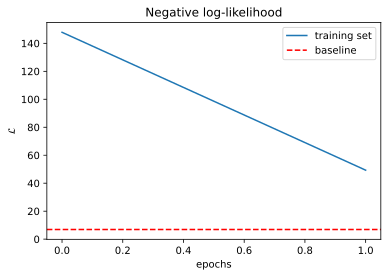

epoch 1/1


  0%|          | 0/390 [00:00<?, ?it/s]

NLL: 34.49900859854273 | Baseline: 6.907755278982137


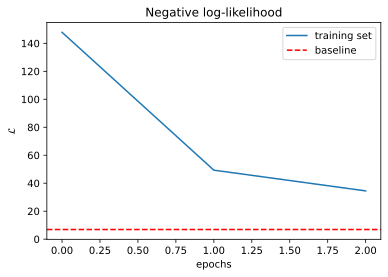

epoch 1/1


  0%|          | 0/390 [00:00<?, ?it/s]

NLL: 26.85126919549873 | Baseline: 6.907755278982137


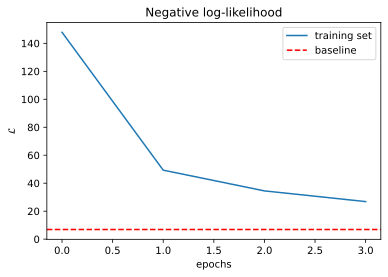

In [18]:
period_epochs = 1
periods = 3
batch_size = 200
max_bond = 300


nlls, samples = training_and_probing(
    period_epochs,
    periods,
    mps,
    _imgs,
    img_cache,
    batch_size,
    lr,
    val_imgs = None,
    period_samples = 0,
    corrupted_set = None,
    plot = True,
    max_bond = max_bond)

In [ ]:
bdims_imshow(mps,(14,14))

In [ ]:
plot_img(generate_sample(mps),(14,14))